In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Creditcard_data.csv")

X = df.drop('Class', axis=1)
y = df['Class']

In [3]:
# Random Oversmapling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

df_balanced = pd.concat([X_resampled, y_resampled], axis=1)

print(f"Original Class Distribution: {Counter(y)}")
print(f"Balanced Class Distribution: {Counter(y_resampled)}")

Original Class Distribution: Counter({0: 763, 1: 9})
Balanced Class Distribution: Counter({0: 763, 1: 763})


In [4]:
#we find sample size using the formula from lecture class
Z = 1.96
p = 0.5
E = 0.05
n = math.ceil((Z**2 * p * (1-p)) / (E**2))
print(f"Target Sample Size: {n}")

Target Sample Size: 385


In [5]:
# Simple Random Sampling
def sample_simple_random(data, size):
    return data.sample(n=size, random_state=42)

# Systematic Sampling
def sample_systematic(data, size):
    step = len(data) // size
    indices = np.arange(0, len(data), step)[:size]
    return data.iloc[indices]

# Stratified Sampling
def sample_stratified(data, size):
    unique_classes = data['Class'].unique()
    n_per_class = size // len(unique_classes)

    samples = []
    for c in unique_classes:
        class_subset = data[data['Class'] == c]

        n_sample = min(n_per_class, len(class_subset))
        samples.append(class_subset.sample(n=n_sample, random_state=42))
    return pd.concat(samples)

In [6]:
# Cluster Sampling
def sample_cluster(data, size):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
    data['cluster_label'] = kmeans.fit_predict(data.drop('Class', axis=1))

    selected_clusters = [0, 2, 4, 5] # Pre-selected for reproducibility
    sample_data = data[data['cluster_label'].isin(selected_clusters)]

    if len(sample_data) > size:
        return sample_data.sample(n=size, random_state=42).drop('cluster_label', axis=1)
    return sample_data.drop('cluster_label', axis=1)

# Bootstrap Sampling
def sample_bootstrap(data, size):
    return data.sample(n=size, replace=True, random_state=42)

In [7]:
# Create the 5 samples
samples = {
    "Random": sample_simple_random(df_balanced, n),
    "Stratified": sample_systematic(df_balanced, n),
    "Systematic": sample_stratified(df_balanced, n),
    "Cluster-based": sample_cluster(df_balanced.copy(), n),
    "Bootstrap": sample_bootstrap(df_balanced, n)
}

In [8]:
models = {
    "Logistic": LogisticRegression(random_state=42, max_iter=3000),
    "Decision tree": DecisionTreeClassifier(random_state=42),
    "random forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Gradient boost": GradientBoostingClassifier(random_state=42)
}

In [9]:
results = {}

for model_name, model in models.items():
    print(f"Running {model_name}...")
    results[model_name] = {}

    for sample_name, sample_df in samples.items():
        X_sample = sample_df.drop('Class', axis=1)
        y_sample = sample_df['Class']

        X_train, X_test, y_train, y_test = train_test_split(
            X_sample, y_sample, test_size=0.2, random_state=42
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        results[model_name][sample_name] = round(acc * 100, 2)

Running Logistic...
Running Decision tree...
Running random forest...
Running SVM...
Running Gradient boost...


In [10]:
print("\nFinal Accuracy Table:")
final_df = pd.DataFrame(results)
print(final_df)
final_df.to_csv("sampling_assignment_results.csv")


Final Accuracy Table:
               Logistic  Decision tree  random forest    SVM  Gradient boost
Random            88.31           97.4           98.7  92.21           94.81
Stratified        89.61           97.4          100.0  94.81           97.40
Systematic        90.91           98.7           98.7  98.70           97.40
Cluster-based     90.91           98.7          100.0  98.70          100.00
Bootstrap         96.10           97.4           98.7  96.10           98.70


In [11]:
for model in final_df.columns:
    best_sampling_tech = final_df[model].idxmax()
    best_accuracy = final_df[model].max()

    print(f"Model {model}: Best technique is {best_sampling_tech} with accuracy {best_accuracy}%")

Model Logistic: Best technique is Bootstrap with accuracy 96.1%
Model Decision tree: Best technique is Systematic with accuracy 98.7%
Model random forest: Best technique is Stratified with accuracy 100.0%
Model SVM: Best technique is Systematic with accuracy 98.7%
Model Gradient boost: Best technique is Cluster-based with accuracy 100.0%



Graph saved as 'sampling_model_comparison_graph.png'


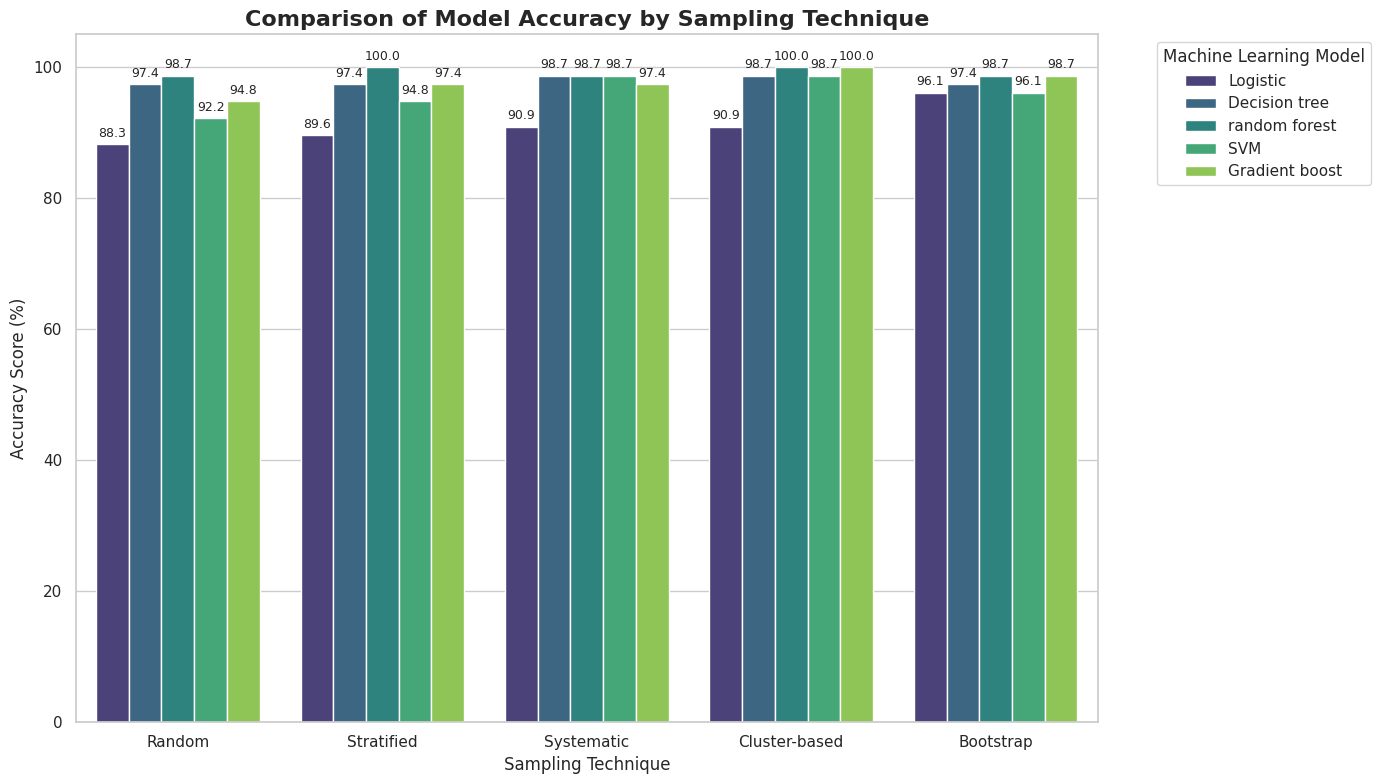

In [12]:
sns.set_theme(style="whitegrid")
plot_df = final_df.reset_index().melt(id_vars='index', var_name='Model', value_name='Accuracy')
plot_df.rename(columns={'index': 'Sampling Technique'}, inplace=True)

plt.figure(figsize=(14, 8))
chart = sns.barplot(
    data=plot_df,
    x='Sampling Technique',
    y='Accuracy',
    hue='Model',
    palette='viridis'
)

plt.title('Comparison of Model Accuracy by Sampling Technique', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy Score (%)', fontsize=12)
plt.xlabel('Sampling Technique', fontsize=12)
plt.legend(title='Machine Learning Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 105)

for container in chart.containers:
    chart.bar_label(container, fmt='%.1f', padding=3, fontsize=9)

plt.tight_layout()
plt.savefig('sampling_model_comparison_graph.png', dpi=300)
print("\nGraph saved as 'sampling_model_comparison_graph.png'")
plt.show()